In [1]:
from __future__ import absolute_import, division
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F
from trainingUtils import MultipleOptimizer, MultipleScheduler, compute_kernel, compute_mmd
from models import Encoder,Decoder,VAE,CellStateEncoder,CellStateDecoder, CellStateVAE,SimpleEncoder,PriorDiscriminator,LocalDiscriminator
# import argparse
import numpy as np
import pandas as pd
import sys
import random
import os
from IPython.display import clear_output
from matplotlib import pyplot as plt
import math

#from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.metrics import confusion_matrix
from evaluationUtils import r_square,get_cindex,pearson_r,pseudoAccuracy

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

#os.environ['CUDA_LAUNCH_BLOCKING'] = "0"
#os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [2]:
device = torch.device('cuda')

In [3]:
# Initialize environment and seeds for reproducability
torch.backends.cudnn.benchmark = True


def seed_everything(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.benchmark = False
    
# Read data
# cmap = pd.read_csv('../preprocessing/preprocessed_data/cmap_landmarks_HT29_A375.csv',index_col = 0)
cmap = pd.read_csv('../preprocessing/preprocessed_data/cmap_HA1E_PC3.csv',index_col = 0)

gene_size = len(cmap.columns)
samples = cmap.index.values
# gene_size = len(cmap_tf.columns)
# samples = cmap_tf.index.values

# sampleInfo = pd.read_csv('../preprocessing/preprocessed_data/conditions_HT29_A375.csv',index_col = 0)
sampleInfo_a375 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/alldata/pc3_unpaired.csv',index_col=0)
sampleInfo_ht29 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/alldata/ha1e_unpaired.csv',index_col=0)
sampleInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/alldata/paired_pc3_ha1e.csv',index_col=0)

In [4]:
# # Network
# # encoder_a375 = Encoder(gene_size,[640,384],292,dropRate=0.1, activation=torch.nn.ELU())
# # decoder_a375 = Decoder(292,[384,640],gene_size,dropRate=0.2, activation=torch.nn.ELU())
# encoder_a375 = Encoder(gene_size,[4096,2048],1024,dropRate=0.1, activation=torch.nn.ELU())
# decoder_a375 = Decoder(1024,[2048,4096],gene_size,dropRate=0.2, activation=torch.nn.ELU())
# autoencoder_a375 = VAE(encoder_a375,decoder_a375,device).to(device)

In [5]:
# # Network
# # encoder_ht29 = Encoder(gene_size,[640,384],292,dropRate=0.1, activation=torch.nn.ELU())
# # decoder_ht29 = Decoder(292,[384,640],gene_size,dropRate=0.2, activation=torch.nn.ELU())
# encoder_ht29 = Encoder(gene_size,[4096,2048],1024,dropRate=0.1, activation=torch.nn.ELU())
# decoder_ht29 = Decoder(1024,[2048,4096],gene_size,dropRate=0.2, activation=torch.nn.ELU())
# autoencoder_ht29 = VAE(encoder_ht29,decoder_ht29,device).to(device)

In [6]:
class CellBinaryClassifier(torch.nn.Module):
    def __init__(self,in_channel,hidden_layers,drop_in=0.5,drop=0.2,bn=0.6,bias=True):
        super(CellBinaryClassifier, self).__init__()
        self.drop_in = drop_in
        self.num_hidden_layers = len(hidden_layers)
        self.bias = bias
        self.bn = torch.nn.ModuleList()
        self.linear_layers = torch.nn.ModuleList()
        self.dropouts = torch.nn.ModuleList()
        self.activations = torch.nn.ModuleList()
        self.linear_layers.append(torch.nn.Linear(in_channel, hidden_layers[0], bias=bias))
        self.bn.append(torch.nn.BatchNorm1d(num_features=hidden_layers[0], momentum=bn))
        self.dropouts.append(torch.nn.Dropout(drop))
        self.activations.append(torch.nn.ReLU())
        for i in range(1, len(hidden_layers)):
            self.linear_layers.append(torch.nn.Linear(hidden_layers[i - 1], hidden_layers[i], 
                                                      bias=bias))
            self.bn.append(torch.nn.BatchNorm1d(num_features=hidden_layers[i], momentum=bn))
            self.dropouts.append(torch.nn.Dropout(drop))
            self.activations.append(torch.nn.ReLU())
        self.out_linear = torch.nn.Linear(hidden_layers[i],2,bias=bias)
        self.softmax = torch.nn.Softmax(dim=1)
        if self.drop_in>0:
            self.InputDrop = torch.nn.Dropout(self.drop_in)
        
        self.init_emb()

    def init_emb(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.fill_(0.0)
    
    def forward(self,x):
        if self.drop_in>0:
            x = self.InputDrop(x)
        for i in range(self.num_hidden_layers):
            x = self.linear_layers[i](x)
            x = self.bn[i](x)
            x = self.activations[i](x)
            x = self.dropouts[i](x)
            
        return self.softmax(self.out_linear(x))
    
    def L2Regularization(self, L2):

        weightLoss = 0.
        biasLoss = 0.
        for i in range(self.num_hidden_layers):
            weightLoss = weightLoss + L2 * torch.sum((self.linear_layers[i].weight)**2)
            if self.bias==True:
                biasLoss = biasLoss + L2 * torch.sum((self.linear_layers[i].bias)**2)
        L2Loss = biasLoss + weightLoss
        return(L2Loss)

In [7]:
# Network
decoder_a375 = Decoder(1024,[2048,4096],gene_size,dropRate=0.2, activation=torch.nn.ELU()).to(device)
decoder_ht29 = Decoder(1024,[2048,4096],gene_size,dropRate=0.2, activation=torch.nn.ELU()).to(device)
    
# Infomax
#master_encoder = SimpleEncoder(gene_size,[640,384],292,dropRate=0.1, activation=torch.nn.ELU())#.to(device)
encoder_a375 = SimpleEncoder(gene_size,[4096,2048],1024,dropRate=0.1, activation=torch.nn.ELU()).to(device)
encoder_ht29 = SimpleEncoder(gene_size,[4096,2048],1024,dropRate=0.1, activation=torch.nn.ELU()).to(device)
prior_d = PriorDiscriminator(1024).to(device)
local_d = LocalDiscriminator(1024,1024).to(device)
classifier = CellBinaryClassifier(in_channel=1024,hidden_layers=[512,256,128],drop_in=0.5,drop=0.25).to(device)

In [10]:
# Create a train generators
def getSamples(N, batchSize):
    order = np.random.permutation(N)
    outList = []
    while len(order)>0:
        outList.append(order[0:batchSize])
        order = order[batchSize:]
    return outList

In [11]:
NUM_EPOCHS = 1000
#bs = 512
bs_a375 = 178
bs_ht29 = 154
bs_paired = 90
beta=1.0
class_criterion = torch.nn.CrossEntropyLoss()

In [12]:
allParams = list(decoder_a375.parameters()) +list(decoder_ht29.parameters())
allParams = allParams + list(encoder_a375.parameters()) +list(encoder_ht29.parameters())
allParams = allParams + list(prior_d.parameters()) + list(local_d.parameters())
allParams = allParams + list(classifier.parameters())
optimizer = torch.optim.Adam(allParams, lr= 0.001, weight_decay=0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=300,gamma=0.8)

N_paired = len(sampleInfo_paired)
N_a375 = len(sampleInfo_a375)
N_ht29 = len(sampleInfo_ht29)
N = N_a375
if N_ht29>N:
    N=N_ht29

curLoss = []
curR2 = []
curPearson = []
curMSE = []

In [8]:
# allParams = list(autoencoder_a375.parameters()) +list(autoencoder_ht29.parameters())
# optimizer = torch.optim.Adam(allParams, lr= 0.001, weight_decay=0)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=300,gamma=0.8)

# N_paired = len(sampleInfo_paired)
# N_a375 = len(sampleInfo_a375)
# N_ht29 = len(sampleInfo_ht29)
# N = N_a375
# if N_ht29>N:
#     N=N_ht29
# curLoss = []
# curR2 = []
# curPearson = []
# curMSE = []

In [14]:
stats = {}
stats['loss'] = float('nan')*np.ones(NUM_EPOCHS)
stats['lossSTD'] = float('nan')*np.ones(NUM_EPOCHS)
stats['R2'] = float('nan')*np.ones(NUM_EPOCHS)
stats['R2STD'] = float('nan')*np.ones(NUM_EPOCHS)
stats['pearson_r'] = float('nan')*np.ones(NUM_EPOCHS)
stats['pearson_rSTD'] = float('nan')*np.ones(NUM_EPOCHS)
stats['MSE'] = float('nan')*np.ones(NUM_EPOCHS)
stats['MSESTD'] = float('nan')*np.ones(NUM_EPOCHS)

In [15]:
#randomMSE = torch.mean(torch.mean((x.detach() - torch.mean(x.detach()))**2,dim=1))
#print(randomMSE)

In [16]:
# recon_loss = torch.nn.MSELoss()

In [17]:
for e in range(0, NUM_EPOCHS):
    decoder_a375.train()
    decoder_ht29.train()
    encoder_a375.train()
    encoder_ht29.train()
    prior_d.train()
    local_d.train()
    
    trainloader_a375 = getSamples(N_a375, bs_a375)
    len_a375 = len(trainloader_a375)
    trainloader_ht29 = getSamples(N_ht29, bs_ht29)
    len_ht29 = len(trainloader_ht29)
    trainloader_paired = getSamples(N_paired, bs_paired)
    len_paired = len(trainloader_paired)

    lens = [len_a375,len_ht29,len_paired]
    maxLen = np.max(lens)

    if maxLen>lens[0]:
        trainloader_suppl = getSamples(N_a375, bs_a375)
        for jj in range(maxLen-lens[0]):
            trainloader_a375.insert(jj,trainloader_suppl[jj])
        
    if maxLen>lens[1]:
        trainloader_suppl = getSamples(N_ht29, bs_ht29)
        for jj in range(maxLen-lens[1]):
            trainloader_ht29.insert(jj,trainloader_suppl[jj])
        
    if maxLen>lens[2]:
        trainloader_suppl = getSamples(N_paired, bs_paired)
        for jj in range(maxLen-lens[2]):
            trainloader_paired.insert(jj,trainloader_suppl[jj])
    #for dataIndex in trainloader:
    for j in range(maxLen):
        dataIndex_a375 = trainloader_a375[j]
        dataIndex_ht29 = trainloader_ht29[j]
        dataIndex_paired = trainloader_paired[j]
            
        df_pairs = sampleInfo_paired.iloc[dataIndex_paired,:]
        df_a375 = sampleInfo_a375.iloc[dataIndex_a375,:]
        df_ht29 = sampleInfo_ht29.iloc[dataIndex_ht29,:]
        paired_inds = len(df_pairs)
                      
        X_a375 = torch.tensor(np.concatenate((cmap.loc[df_pairs['sig_id.x']].values,
                                              cmap.loc[df_a375.sig_id].values))).float().to(device)
        X_ht29 = torch.tensor(np.concatenate((cmap.loc[df_pairs['sig_id.y']].values,
                                              cmap.loc[df_ht29.sig_id].values))).float().to(device)
            
            
        conditions = np.concatenate((df_pairs.conditionId.values,
                                     df_a375.conditionId.values,
                                     df_pairs.conditionId.values,
                                     df_ht29.conditionId.values))
        size = conditions.size
        conditions = conditions.reshape(size,1)
        conditions = conditions == conditions.transpose()
        conditions = conditions*1
        mask = torch.tensor(conditions).to(device).detach()
        pos_mask = mask
        neg_mask = 1 - mask
        log_2 = math.log(2.)
        optimizer.zero_grad()
       
        z_a375 = encoder_a375(X_a375)
        z_ht29 = encoder_ht29(X_ht29)
            
        z_un = local_d(torch.cat((z_a375, z_ht29), 0))
        res_un = torch.matmul(z_un, z_un.t())
            
        y_pred_a375 = decoder_a375(z_a375)
        fitLoss_a375 = torch.mean(torch.sum((y_pred_a375 - X_a375)**2,dim=1))
        L2Loss_a375 = decoder_a375.L2Regularization(0.01) + encoder_a375.L2Regularization(0.01)
        loss_a375 = fitLoss_a375 + L2Loss_a375
            
        y_pred_ht29 = decoder_ht29(z_ht29)
        fitLoss_ht29 = torch.mean(torch.sum((y_pred_ht29 - X_ht29)**2,dim=1))
        L2Loss_ht29 = decoder_ht29.L2Regularization(0.01) + encoder_ht29.L2Regularization(0.01)
        loss_ht29 = fitLoss_ht29 + L2Loss_ht29
        
        silimalityLoss = torch.mean(torch.sum((z_a375[0:paired_inds,:] - z_ht29[0:paired_inds,:])**2,dim=-1))
            
        p_samples = res_un * pos_mask.float()
        q_samples = res_un * neg_mask.float()

        Ep = log_2 - F.softplus(- p_samples)
        Eq = F.softplus(-q_samples) + q_samples - log_2

        Ep = (Ep * pos_mask.float()).sum() / pos_mask.float().sum()
        Eq = (Eq * neg_mask.float()).sum() / neg_mask.float().sum()
        mi_loss = Eq - Ep

        prior = torch.rand_like(torch.cat((z_a375, z_ht29), 0))

        term_a = torch.log(prior_d(prior)).mean()
        term_b = torch.log(1.0 - prior_d(torch.cat((z_a375, z_ht29), 0))).mean()
        prior_loss = -(term_a + term_b) * beta
        
        labels = classifier(torch.cat((z_a375, z_ht29), 0))
        true_labels = torch.cat((torch.ones(z_a375.shape[0]),
                                 torch.zeros(z_ht29.shape[0])),0).long().to(device)
        entropy = class_criterion(labels,true_labels)
            
        loss = loss_a375 + loss_ht29 + mi_loss + prior_loss + silimalityLoss + 100*entropy +classifier.L2Regularization(1e-2)
        
        
        loss.backward()

        optimizer.step()
        
        pearson_a375 = pearson_r(y_pred_a375.detach().flatten(), X_a375.detach().flatten())
        r2_a375 = r_square(y_pred_a375.detach().flatten(), X_a375.detach().flatten())
        mse_a375 = torch.mean(torch.mean((y_pred_a375.detach() - X_a375.detach())**2,dim=1))
        
        pearson_ht29 = pearson_r(y_pred_ht29.detach().flatten(), X_ht29.detach().flatten())
        r2_ht29 = r_square(y_pred_ht29.detach().flatten(), X_ht29.detach().flatten())
        mse_ht29 = torch.mean(torch.mean((y_pred_ht29.detach() - X_ht29.detach())**2,dim=1))
        
        curMSE.append(0.5*(mse_a375.item()+mse_ht29.item()))
        curR2.append(0.5*(r2_a375.item()+r2_ht29.item()))
        curPearson.append(0.5*(pearson_a375.item()+pearson_ht29.item()))
        curLoss.append(loss.item())
    scheduler.step()
    #if (e==0 or (e+1)%50==0):
    outString = 'Epoch={:.0f}/{:.0f}'.format(e+1,NUM_EPOCHS)
    outString += ', r2_a375={:.4f}'.format(r2_a375.item())
    outString += ', pearson_a375={:.4f}'.format(pearson_a375.item())
    outString += ', MSE_a375={:.4f}'.format(mse_a375.item())
    outString += ', r2_ht29={:.4f}'.format(r2_ht29.item())
    outString += ', pearson_ht29={:.4f}'.format(pearson_ht29.item())
    outString += ', MSE_ht29={:.4f}'.format(mse_ht29.item())
    outString += ', MI Loss={:.4f}'.format(mi_loss.item())
    outString += ', Prior Loss={:.4f}'.format(prior_loss.item())
    outString += ', Entropy Loss={:.4f}'.format(entropy.item())
    outString += ', loss={:.4f}'.format(loss.item())
    print(outString)
    stats['loss'][e] = np.mean(np.array(curLoss))
    stats['lossSTD'][e] = np.std(np.array(curLoss))
    stats['pearson_r'][e]= np.mean(np.array(curPearson))
    stats['pearson_rSTD'][e] = np.std(np.array(curPearson))
    stats['R2'][e]= np.mean(np.array(curR2))
    stats['R2STD'][e] = np.std(np.array(curR2))
    stats['MSE'][e]= np.mean(np.array(curMSE))
    stats['MSESTD'][e] = np.std(np.array(curMSE))
    clear_output(wait=True)

Epoch=1000/1000, r2_a375=0.8937, pearson_a375=0.9517, MSE_a375=0.0952, r2_ht29=0.9021, pearson_ht29=0.9502, MSE_ht29=0.1060, MI Loss=-0.7087, Prior Loss=0.0000, Entropy Loss=0.3749, loss=2518.3042


In [18]:
decoder_a375.eval()
decoder_ht29.eval()
encoder_a375.eval()
encoder_ht29.eval()
prior_d.eval()
local_d.eval()
classifier.eval()
print('Evaluate mode')

Evaluate mode


In [19]:
x_a375 = torch.tensor(np.concatenate((cmap.loc[sampleInfo_paired['sig_id.x']].values,
                                      cmap.loc[sampleInfo_a375.sig_id].values))).float().to(device)
x_ht29 = torch.tensor(np.concatenate((cmap.loc[sampleInfo_paired['sig_id.y']].values,
                                      cmap.loc[sampleInfo_ht29.sig_id].values))).float().to(device)
# z_latent_a375 , xhat_a375 = autoencoder_a375(x_a375)
# z_latent_ht29 , xhat_ht29 = autoencoder_ht29(x_ht29)
z_latent_a375  = encoder_a375(x_a375)
xhat_a375 = decoder_a375(z_latent_a375)
z_latent_ht29  = encoder_ht29(x_ht29)
xhat_ht29 = decoder_ht29(z_latent_ht29)

In [26]:
labels = classifier(torch.cat((z_latent_a375, z_latent_ht29), 0))
true_labels = torch.cat((torch.ones(z_latent_a375.shape[0]).view(z_latent_a375.shape[0],1),
                         torch.zeros(z_latent_ht29.shape[0]).view(z_latent_ht29.shape[0],1)),0).long()
_, predicted = torch.max(labels, 1)
predicted = predicted.cpu().numpy()
cf_matrix = confusion_matrix(true_labels.numpy(),predicted)
tn, fp, fn, tp = cf_matrix.ravel()
class_acc = (tp+tn)/predicted.size
f1 = 2*tp/(2*tp+fp+fn)
print('F1 score:%s'%f1)
print('Accuracy:%s'%class_acc)

F1 score:0.9996615905245347
Accuracy:0.9996056782334385


In [27]:
### Save embeddings ###
Embs_a375 = pd.DataFrame(z_latent_a375.detach().cpu().numpy())
Embs_a375.index = np.concatenate((sampleInfo_paired['sig_id.x'].values,sampleInfo_a375.sig_id.values))
Embs_a375.columns = ['z'+str(i) for i in range(1024)]
Embs_a375.to_csv('../results/trained_embs_all/AllEmbs_MI_pc3_withclass.csv')
display(Embs_a375)

,z0,z1,z2,z3,z4,z5,z6,z7,z8,z9,...,z1014,z1015,z1016,z1017,z1018,z1019,z1020,z1021,z1022,z1023
ASG002_PC3_24H:B07,0.084165,-0.282866,0.194297,-0.173088,0.053098,0.008374,-0.070605,0.199455,0.146483,0.634891,...,-0.464844,-0.496080,1.046736,-0.176101,-0.267111,-0.385607,0.489603,-0.282838,0.255659,0.029781
PBIOA017_PC3_24H:G07,0.297650,0.723474,-1.715533,-0.477011,-0.010182,-0.273578,-0.141500,0.696504,0.249116,-0.148086,...,-0.991016,0.115972,0.143522,-0.733313,-0.430543,0.399422,-0.387624,-0.529235,0.143531,0.148648
LJP006_PC3_24H:G19,0.766415,-0.459978,0.352857,-0.051889,-0.033388,-0.774758,0.077399,0.032808,-0.339812,-0.097679,...,-0.698046,0.107864,0.035869,-0.335787,0.400973,0.181944,-0.130701,-0.112291,0.521323,0.221557
CPC001_PC3_24H:I01,0.044317,1.294891,0.100227,-0.063893,0.445755,0.332100,-0.512944,0.860311,0.249356,-0.383790,...,-0.366743,-0.310489,0.094619,-0.233505,0.438999,-0.223034,0.322599,-0.083007,0.368486,1.111391
CPC001_PC3_24H:B15,-0.053078,0.338827,0.182279,-0.219549,-0.335992,0.119582,-0.545158,0.229124,0.695732,-0.470803,...,0.333655,-0.102462,0.102899,-0.215013,-0.136826,-0.007686,-0.290543,-0.029088,0.339313,0.344733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DOSVAL004_PC3_24H:BRD-K42197878:20,-0.517993,-0.466395,-0.115182,-0.348306,0.082973,-0.241834,0.108636,0.354869,0.733307,-0.083069,...,-0.572884,0.325997,-0.593406,0.002679,-0.737554,0.084161,-0.556606,0.099536,0.268207,0.215556
DOSVAL003_PC3_24H:BRD-K06852269:10,-0.026511,0.148867,-0.592797,0.643348,0.250200,0.194656,-0.036544,0.655330,0.285194,-0.682561,...,-0.157405,-0.937189,0.237101,0.289537,-0.130510,-0.419587,-0.588473,-0.006181,0.107172,-0.412093
DOSVAL003_PC3_24H:BRD-K31126514:20,0.400377,0.425242,0.391585,0.116545,0.115616,0.457984,-0.171242,-0.009175,0.291209,-0.401940,...,-0.530658,-0.345634,-0.177532,1.028847,-0.159570,-0.104187,-0.704475,0.447146,0.107465,-0.364292
DOSVAL001_PC3_24H:BRD-K60763357:10.036,0.153902,-0.565084,0.132985,-0.192844,0.089943,0.695755,-0.362662,0.595221,0.489115,0.699094,...,-0.363332,-0.547062,0.687610,-0.382174,-0.762700,0.310617,0.217786,-0.130204,-0.605407,0.122001


In [28]:
### Save embeddings ###
Embs_ht29 = pd.DataFrame(z_latent_ht29.detach().cpu().numpy())
Embs_ht29.index = np.concatenate((sampleInfo_paired['sig_id.y'].values,sampleInfo_ht29.sig_id.values))
Embs_ht29.columns = ['z'+str(i) for i in range(1024)]
Embs_ht29.to_csv('../results/trained_embs_all/AllEmbs_MI_ha1e_withclass.csv')
display(Embs_ht29)

,z0,z1,z2,z3,z4,z5,z6,z7,z8,z9,...,z1014,z1015,z1016,z1017,z1018,z1019,z1020,z1021,z1022,z1023
CPC006_HA1E_24H:L05,0.133171,-0.312513,0.680394,-0.197915,0.201950,-0.149673,0.218677,0.362956,0.087929,0.966785,...,-0.535577,-0.516098,1.598489,-0.264383,-0.268744,-0.619801,0.308276,-0.064823,0.342089,0.012770
PBIOA017_HA1E_24H:G07,0.405738,0.689336,-2.049619,-0.693695,0.243061,-0.298689,-0.266771,0.672703,0.574266,-0.316219,...,-1.275333,-0.074405,0.076981,-0.698315,-0.386762,0.506311,-0.427180,-0.327615,0.103759,0.092917
LJP006_HA1E_24H:G19,0.963032,-0.454525,0.668738,0.165621,0.280231,-1.016471,0.100046,0.219480,-0.325493,-0.188201,...,-0.967764,0.224135,-0.025924,-0.437457,0.815282,0.070859,0.096575,-0.123365,0.843452,0.215733
CPC001_HA1E_24H:BRD-K89930444-001-01-9:10,-0.146621,1.560345,0.266607,0.016843,0.569559,0.431991,-0.366799,1.229936,0.232879,-0.605151,...,-0.507938,-0.526773,-0.094124,-0.034060,0.781265,-0.324718,0.163380,-0.070719,0.366008,1.423117
CPC001_HA1E_24H:BRD-K59469039-001-03-1:10,-0.094240,0.324841,0.388463,-0.230026,-0.515369,0.070340,-0.721209,0.106501,0.896748,-0.582767,...,0.465316,-0.267825,0.043379,-0.239662,-0.239770,-0.110553,-0.078141,-0.084765,0.204877,0.273850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DOSVAL004_HA1E_24H:BRD-K28934562:20,-0.351744,-0.417904,-0.265423,0.246186,0.525158,-0.220998,-0.208565,-0.004768,-0.243184,0.021024,...,-0.344937,0.071737,0.414051,-0.408596,0.438926,-0.376485,0.378945,0.170069,-0.466953,0.370937
DOSVAL003_HA1E_24H:BRD-K89824424:20,0.041794,0.219328,0.021924,0.075768,0.475331,0.224328,-0.089837,0.057460,0.621621,0.013386,...,-0.226394,-0.010924,0.297378,-0.808539,-0.505123,-0.078685,0.584478,0.038761,0.043291,-1.102311
DOSVAL004_HA1E_24H:BRD-K31380618:20,-0.372096,0.268770,-0.155603,-0.355296,0.709693,0.155079,-0.068097,-0.327301,0.081362,-0.679076,...,-0.389287,-0.183569,0.652602,-0.236159,0.317856,-0.223254,0.232502,0.884866,0.431628,0.920212
DOSVAL001_HA1E_24H:BRD-K28484895:10.4003,0.094992,-0.672635,0.396670,-0.491469,-0.555040,0.018707,-0.218236,0.244259,-0.127325,0.044301,...,-0.188543,-1.080490,-0.485077,0.035554,0.014027,0.181228,-1.229997,-0.413863,0.123383,-0.590541


In [29]:
r2_a375 = r_square(xhat_a375.detach().flatten(), x_a375.detach().flatten())
pearson_a375 = pearson_r(xhat_a375.detach().flatten(), x_a375.detach().flatten())
mse_a375 = torch.mean(torch.mean((xhat_a375 - x_a375)**2,dim=1))
rhos =[]
for jj in range(xhat_a375.shape[0]):
    rho,p = spearmanr(x_a375[jj,:].detach().cpu().numpy(),xhat_a375[jj,:].detach().cpu().numpy())
    rhos.append(rho)
Spear_a375=np.mean(rhos)
acc = pseudoAccuracy(x_a375.detach().cpu(),xhat_a375.detach().cpu(),eps=1e-6)
Accuracy_a375=np.mean(acc)
print('R^2 a375: %s'%r2_a375.item())
print('Pearson correlation a375: %s'%pearson_a375.item())
print('MSE a375: %s'%mse_a375.item())
print('Spearman correlation ht29: %s'%Spear_a375)
print('Pseudo-accuracy ht29: %s'%Accuracy_a375)

R^2 a375: 0.9613711833953857
Pearson correlation a375: 0.9823259711265564
MSE a375: 0.03597153723239899
Spearman correlation ht29: 0.9736521097634024
Pseudo-accuracy ht29: 0.9357103050529157


In [30]:
r2_ht29 = r_square(xhat_ht29.detach().flatten(), x_ht29.detach().flatten())
pearson_ht29 = pearson_r(xhat_ht29.detach().flatten(), x_ht29.detach().flatten())
mse_ht29 = torch.mean(torch.mean((xhat_ht29 - x_ht29)**2,dim=1))
rhos =[]
for jj in range(xhat_ht29.shape[0]):
    rho,p = spearmanr(x_ht29[jj,:].detach().cpu().numpy(),xhat_ht29[jj,:].detach().cpu().numpy())
    rhos.append(rho)
Spear_ht29=np.mean(rhos)
acc = pseudoAccuracy(x_ht29.detach().cpu(),xhat_ht29.detach().cpu(),eps=1e-6)
Accuracy_ht29=np.mean(acc)
print('R^2 ht29: %s'%r2_ht29.item())
print('Pearson correlation ht29: %s'%pearson_ht29.item())
print('MSE ht29: %s'%mse_ht29.item())
print('Spearman correlation ht29: %s'%Spear_ht29)
print('Pseudo-accuracy ht29: %s'%Accuracy_ht29)

R^2 ht29: 0.9699994325637817
Pearson correlation ht29: 0.9863080382347107
MSE ht29: 0.031315773725509644
Spearman correlation ht29: 0.9807080982058557
Pseudo-accuracy ht29: 0.9431815564614568


In [31]:
paired_inds = len(sampleInfo_paired)

In [32]:
x_a375_equivalent = x_a375[0:paired_inds,:]
x_ht29_equivalent = x_ht29[0:paired_inds,:]
pearDirect = pearson_r(x_a375_equivalent.detach().flatten(), x_ht29_equivalent.detach().flatten())
rhos =[]
for jj in range(x_a375_equivalent.shape[0]):
    rho,p = spearmanr(x_a375_equivalent[jj,:].detach().cpu().numpy(),x_ht29_equivalent[jj,:].detach().cpu().numpy())
    rhos.append(rho)
Spear_direct=np.mean(rhos)
acc_ht29 = np.mean(pseudoAccuracy(x_ht29_equivalent.detach().cpu(),x_a375_equivalent.detach().cpu(),eps=1e-6))
acc_a375 = np.mean(pseudoAccuracy(x_a375_equivalent.detach().cpu(),x_ht29_equivalent.detach().cpu(),eps=1e-6))
print('Pearson of direct translation: %s'%pearDirect.item())
print('Spearman of direct translation: %s'%Spear_direct)
print('Pdeudo-accuracy of direct translation from a375 to ht29: %s'%acc_ht29)
print('Pdeudo-accuracy of direct translation from ht29 to a375: %s'%acc_a375)

Pearson of direct translation: 0.3224192261695862
Spearman of direct translation: 0.27281385162575944
Pdeudo-accuracy of direct translation from a375 to ht29: 0.592263804012763
Pdeudo-accuracy of direct translation from ht29 to a375: 0.592263804012763


In [33]:
z_latent_a375_equivalent  = encoder_a375(x_a375_equivalent)
x_hat_ht29_equivalent = decoder_ht29(z_latent_a375_equivalent).detach()
r2_ht29 = r_square(x_hat_ht29_equivalent.detach().flatten(), x_ht29_equivalent.detach().flatten())
pearson_ht29 = pearson_r(x_hat_ht29_equivalent.detach().flatten(), x_ht29_equivalent.detach().flatten())
mse_ht29 = torch.mean(torch.mean((x_hat_ht29_equivalent - x_ht29_equivalent)**2,dim=1))
rhos =[]
for jj in range(x_ht29_equivalent.shape[0]):
    rho,p = spearmanr(x_ht29_equivalent[jj,:].detach().cpu().numpy(),x_hat_ht29_equivalent[jj,:].detach().cpu().numpy())
    rhos.append(rho)
Spear_ht29=np.mean(rhos)
acc_ht29 = np.mean(pseudoAccuracy(x_ht29_equivalent.detach().cpu(),x_hat_ht29_equivalent.detach().cpu(),eps=1e-6))
print('Pearson correlation A375 to HT29: %s'%pearson_ht29.item())
print('MSE A375 to HT29: %s'%mse_ht29.item())
print('Spearman A375 to HT29: %s'%Spear_ht29)
print('Pdeudo-accuracy A375 to HT29: %s'%acc_ht29)

Pearson correlation A375 to HT29: 0.9617589712142944
MSE A375 to HT29: 0.12486685067415237
Spearman A375 to HT29: 0.9477311761601879
Pdeudo-accuracy A375 to HT29: 0.9119139040614354


In [34]:
z_latent_ht29_equivalent  = encoder_ht29(x_ht29_equivalent)
x_hat_a375_equivalent = decoder_a375(z_latent_ht29_equivalent).detach()
r2_a375 = r_square(x_hat_a375_equivalent.detach().flatten(), x_a375_equivalent.detach().flatten())
pearson_a375 = pearson_r(x_hat_a375_equivalent.detach().flatten(), x_a375_equivalent.detach().flatten())
mse_a375 = torch.mean(torch.mean((x_hat_a375_equivalent - x_a375_equivalent)**2,dim=1))
rhos =[]
for jj in range(x_a375_equivalent.shape[0]):
    rho,p = spearmanr(x_a375_equivalent[jj,:].detach().cpu().numpy(),x_hat_a375_equivalent[jj,:].detach().cpu().numpy())
    rhos.append(rho)
Spear_a375=np.mean(rhos)
acc_a375 = np.mean(pseudoAccuracy(x_a375_equivalent.detach().cpu(),x_hat_a375_equivalent.detach().cpu(),eps=1e-6))
print('Pearson correlation HT29 to A375: %s'%pearson_a375.item())
print('MSE HT29 to A375: %s'%mse_a375.item())
print('Spearman HT29 to A375: %s'%Spear_a375)
print('Pdeudo-accuracy HT29 to A375: %s'%acc_a375)

Pearson correlation HT29 to A375: 0.9636803865432739
MSE HT29 to A375: 0.06996044516563416
Spearman HT29 to A375: 0.9512967745437491
Pdeudo-accuracy HT29 to A375: 0.9190567182833692


In [ ]:
plt.figure()
plt.scatter(x_a375_equivalent.detach().flatten().cpu().numpy(), 
            x_ht29_equivalent.detach().flatten().cpu().numpy(),
            alpha=0.1)
plt.text(0, 0.9, 'r {:.2f}'.format(pearDirect.item()))
plt.savefig('../figures/pc3_to_ha1e_direct_correlation_allgenes.png',dpi=600)

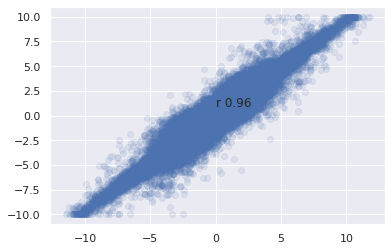

In [36]:
plt.figure()
plt.scatter(x_hat_a375_equivalent.detach().flatten().cpu().numpy(),
            x_a375_equivalent.detach().flatten().cpu().numpy(),
           alpha=0.1)
plt.text(0, 0.9, 'r {:.2f}'.format(pearson_a375.item()))
plt.savefig('../figures/ha1e_to_pc3_translate_correlation_withclass.png',dpi=600)

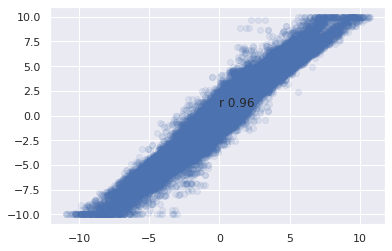

In [37]:
plt.figure()
plt.scatter(x_hat_ht29_equivalent.detach().flatten().cpu().numpy(),
            x_ht29_equivalent.detach().flatten().cpu().numpy(),
           alpha=0.1)
plt.text(0, 0.9, 'r {:.2f}'.format(pearson_ht29.item()))
plt.savefig('../figures/pc3_to_ha1e_translate_correlation_withclass.png',dpi=600)

In [39]:
torch.save(encoder_a375, '../results/trained_models/Encoder_PC3_MI_allgenes_withclass.pth')
torch.save(encoder_ht29, '../results/trained_models/Encoder_HA1E_MI_allgenes_withclass.pth')
torch.save(decoder_a375, '../results/trained_models/Decoder_PC3_MI_allgenes_withclass.pth')
torch.save(decoder_ht29, '../results/trained_models/Decoder_HA1E_MI_allgenes_withclass.pth')
torch.save(local_d, '../results/trained_models/local_d_MI_pc3_ha1e_allgenes_withclass.pth')
torch.save(prior_d, '../results/trained_models/prior_d_MI_pc3_ha1e_allgenes_withclass.pth')
torch.save(classifier,'../results/trained_models/classifier_pc3_ha1e.pth')

/nobackup/users/meimetis/projects/condas/bdvae_rotation/miniconda3/envs/bdvae_rotation/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CellBinaryClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/nobackup/users/meimetis/projects/condas/bdvae_rotation/miniconda3/envs/bdvae_rotation/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Softmax. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
# checkpoint = torch.load('checkpoint_dummyAutoenoderA375_mmd.pth.tar')
# autoencoder.load_state_dict(checkpoint['state_dict'])

In [40]:
def shadePlot(X, Y, STD):
    plt.plot(X, Y)
    curColor = plt.gca().lines[-1].get_color()
    plt.fill_between(X, Y - STD, Y + STD, color=curColor, alpha=0.2)

In [41]:
def movingaverage(values, w):
    moving_averages = np.zeros(values.shape)
    stepsBefore = np.ceil(w/2)
    stepsAfter = np.ceil(w/2)
    for i in range(values.shape[0]):
        start = np.max((i-stepsBefore, 0)).astype(int)
        stop = np.min((i+stepsAfter, values.shape[0])).astype(int)
        moving_averages[i] = np.mean(values[start:stop])
    return moving_averages

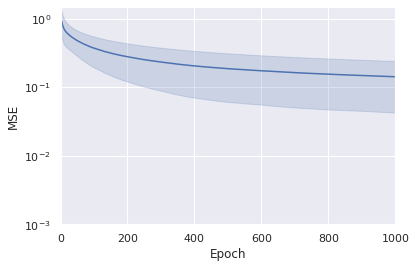

In [42]:
shadePlot(np.array(range(NUM_EPOCHS)), movingaverage(stats['MSE'], 8), movingaverage(stats['MSESTD'], 8))
# plt.plot([0, NUM_EPOCHS], np.array([1, 1])*randomMSE.item(), 'black', linestyle='--')
plt.xlim([0, NUM_EPOCHS])
plt.ylim(bottom=1e-3)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.yscale('log')

Text(0.5, 0, 'Epoch')

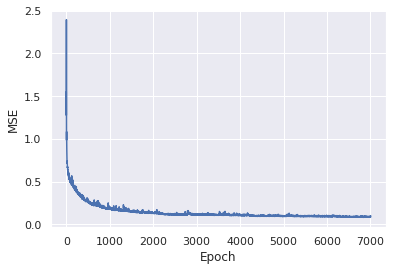

In [44]:
plt.plot(range(len(curMSE)),curMSE)
# plt.plot([0, len(curMSE)], np.array([1, 1])*randomMSE.item(), 'black', linestyle='--')
plt.ylabel('MSE')
plt.xlabel('Epoch')
#plt.yscale('log')

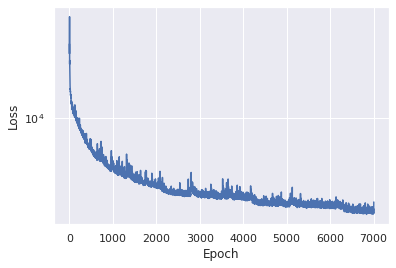

In [45]:
plt.plot(range(len(curLoss)),curLoss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.yscale('log')

Text(0.5, 0, 'Epoch')

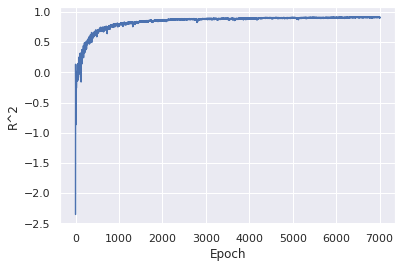

In [46]:
plt.plot(range(len(curR2)),curR2)
plt.ylabel('R^2')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

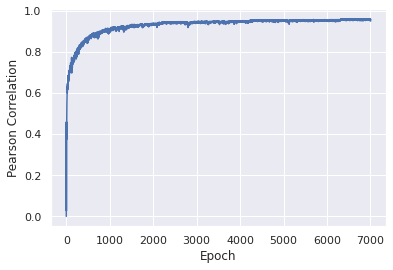

In [47]:
plt.plot(range(len(curPearson)),curPearson)
plt.ylabel('Pearson Correlation')
plt.xlabel('Epoch')

In [48]:
import seaborn as sns
sns.set()

/nobackup/users/meimetis/projects/condas/bdvae_rotation/miniconda3/envs/bdvae_rotation/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


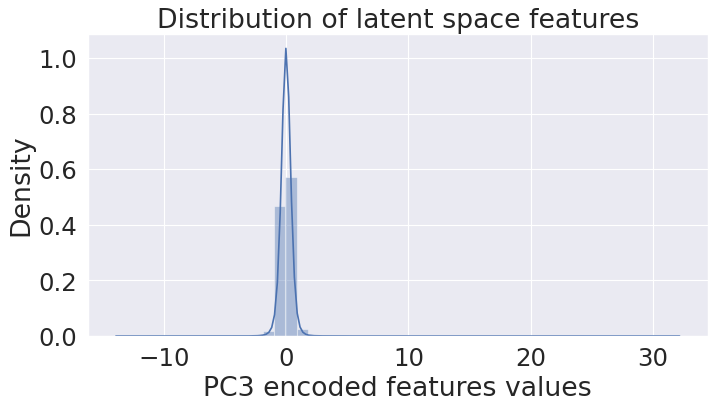

In [49]:
#plt.hist(z_latent_a375.detach().cpu().flatten().numpy())
plt.figure(figsize=(10,5), dpi= 80)
sns.set(font_scale=2)
sns.distplot(z_latent_a375.detach().cpu().flatten().numpy())
plt.xlabel('PC3 encoded features values')
plt.ylabel('Density')
plt.title('Distribution of latent space features')
plt.savefig('../figures/good_trained_ae_pc3_latent_space_allgenes_withclass.png', bbox_inches='tight',dpi=600)

(array([7.290000e+02, 2.981000e+03, 1.282800e+04, 1.132560e+05,
        5.724157e+06, 8.752780e+06, 2.646360e+05, 2.114600e+04,
        3.787000e+03, 7.220000e+02]),
 array([-11.809593 ,  -9.480411 ,  -7.1512284,  -4.8220463,  -2.492864 ,
         -0.1636815,   2.1655009,   4.4946833,   6.8238654,   9.153048 ,
         11.48223  ], dtype=float32),
 <BarContainer object of 10 artists>)

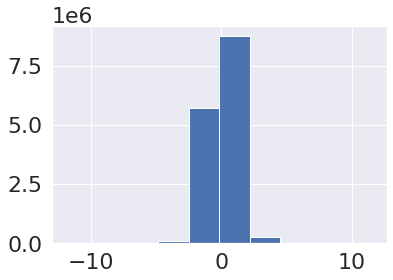

In [50]:
plt.hist(xhat_a375.detach().cpu().flatten().numpy())

(array([2.424000e+03, 6.195000e+03, 2.622400e+04, 2.465220e+05,
        6.857737e+06, 7.361767e+06, 3.546740e+05, 3.274000e+04,
        6.584000e+03, 2.155000e+03]),
 array([-10.000001 ,  -8.000001 ,  -6.0000005,  -4.0000005,  -2.0000002,
          0.       ,   2.0000002,   4.0000005,   6.0000005,   8.000001 ,
         10.000001 ], dtype=float32),
 <BarContainer object of 10 artists>)

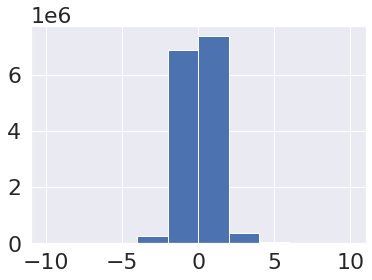

In [51]:
plt.hist(x_a375.detach().cpu().flatten().numpy())

/nobackup/users/meimetis/projects/condas/bdvae_rotation/miniconda3/envs/bdvae_rotation/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


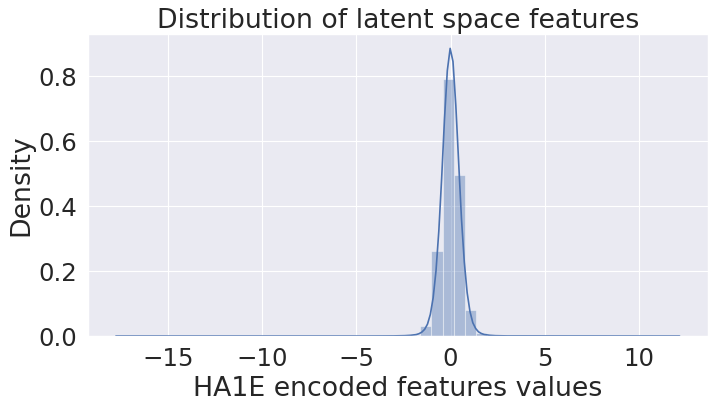

In [56]:
#plt.hist(z_latent_ht29.detach().cpu().flatten().numpy())
plt.figure(figsize=(10,5), dpi= 80)
sns.set(font_scale=2)
sns.distplot(z_latent_ht29.detach().cpu().flatten().numpy())
plt.xlabel('HA1E encoded features values')
plt.ylabel('Density')
plt.title('Distribution of latent space features')
plt.savefig('../figures/good_trained_ae_ha1e_latent_space_allgenes_withclass.png', bbox_inches='tight',dpi=600)

(array([9.750000e+02, 2.984000e+03, 1.251000e+04, 1.232790e+05,
        4.885348e+06, 5.459004e+06, 1.785960e+05, 1.510000e+04,
        2.637000e+03, 6.410000e+02]),
 array([-11.460031  ,  -9.164368  ,  -6.868705  ,  -4.573042  ,
         -2.277379  ,   0.01828384,   2.3139467 ,   4.6096096 ,
          6.9052725 ,   9.200935  ,  11.496598  ], dtype=float32),
 <BarContainer object of 10 artists>)

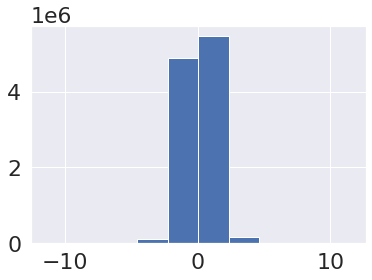

In [57]:
plt.hist(xhat_ht29.detach().cpu().flatten().numpy())

# Important genes : Integrated gradients

In [5]:
import seaborn as sns
sns.set()

In [6]:
encoder_a375=torch.load('../results/trained_models/Encoder_PC3_MI_allgenes_withclass.pth')
# encoder_ht29=torch.load('../results/trained_models/Encoder_HA1E_MI_allgenes_withclass.pth')
# decoder_a375=torch.load('../results/trained_models/Decoder_PC3_MI_allgenes_withclass.pth')
decoder_ht29=torch.load('../results/trained_models/Decoder_HA1E_MI_allgenes_withclass.pth')
# classifier = torch.load('../results/trained_models/classifier_pc3_ha1e.pth')
# decoder_a375.eval()
decoder_ht29.eval()
encoder_a375.eval()
# encoder_ht29.eval()
classifier.eval()
print('Evaluation mode')

NameError: name 'classifier' is not defined

In [ ]:
x_a375 = torch.tensor(np.concatenate((cmap.loc[sampleInfo_paired['sig_id.x']].values,
                                      cmap.loc[sampleInfo_a375.sig_id].values))).float().to(device)
x_ht29 = torch.tensor(np.concatenate((cmap.loc[sampleInfo_paired['sig_id.y']].values,
                                      cmap.loc[sampleInfo_ht29.sig_id].values))).float().to(device)

In [ ]:
paired_inds = len(sampleInfo_paired)
len_samples = x_a375.shape[0]

In [ ]:
# # Classifier importance
# z_1 = torch.tensor(pd.read_csv('../results/trained_embs_all/AllEmbs_MI_pc3_withclass.csv'index_col=0).drop_duplicates().values).to(device)
# z_2 = torch.tensor(pd.read_csv('../results/trained_embs_all/AllEmbs_MI_ha1e_withclass.csv',index_col=0).drop_duplicates().values).to(device)
# z = torch.cat((z_1,z_2),0).float()
# ig = IntegratedGradients(classifier)
# z.requires_grad_()
# attr1 = ig.attribute(z,target=1,n_steps=100, return_convergence_delta=False)
# attr1 = attr1.detach().cpu().numpy()
# attr2 = ig.attribute(z,target=0,n_steps=100, return_convergence_delta=False)
# attr2 = attr2.detach().cpu().numpy()
# df1 = pd.DataFrame(attr1)
# df1.index = cmap.index
# df1.columns = ['z'+str(i) for i in range(1024)]
# df1.to_csv('../results/Importance_results/important_scores_to_classify_as_pc3.csv')
# df2 = pd.DataFrame(attr2)
# df2.index = cmap.index
# df2.columns = ['z'+str(i) for i in range(1024)]
# df2.to_csv('../results/Importance_results/important_scores_to_classify_as_ha1e.csv')

In [ ]:
x_a375_equivalent = x_a375[0:paired_inds,:]

In [ ]:
# x_ht29_equivalent = x_ht29[0:paired_inds,:]

In [ ]:
translator = torch.nn.Sequential(encoder_a375,decoder_ht29)

In [ ]:
translator.eval()
ig = IntegratedGradients(translator)
# ig = IntegratedGradients(encoder_a375)

In [ ]:
# Per sample captum importance translation
hid_dim = 292
scores = torch.zeros ((paired_inds,gene_size)).to(device)
for z in range(gene_size):
    #translator.zero_grad()
    attr, delta = ig.attribute(x_a375_equivalent,target=z,n_steps=10,return_convergence_delta=True) # 10 steps cause it takes to much time
    scores = scores + attr
#grads = grads/gene_size
print(scores)

In [ ]:
# Per output gene input importance translation captum
# 1st dimesion input
# 2nd dimesion output
hid_dim = 292
scores = torch.zeros ((gene_size,gene_size)).to(device)
for z in range(gene_size):
    #translator.zero_grad()
    attr, delta = ig.attribute(x_a375_equivalent,target=z,n_steps=10,return_convergence_delta=True) # 10 steps cause it takes to much time
    scores[:,z] = torch.mean(attr,0) 
print(scores)

In [ ]:
# Per sample captum importance encoding
hid_dim = 292
scores = torch.zeros ((len_samples,gene_size)).to(device)
for z in range(hid_dim):
    #encoder_a375.zero_grad()
    attr, delta = ig.attribute(x_a375,target=z,n_steps=100,return_convergence_delta=True)
    scores = scores + attr 
#grads = grads/hid_dim
print(scores)

In [ ]:
# Per output latent variable input importance translation captum
# 1st dimesion input
# 2nd dimesion output
hid_dim = 292
scores = torch.zeros ((gene_size,hid_dim)).to(device)
for z in range(hid_dim):
    #encoder_a375.zero_grad()
    attr, delta = ig.attribute(x_a375,target=z,n_steps=100,return_convergence_delta=True)
    scores[:,z] = torch.mean(attr,0)
print(scores)

In [ ]:
plt.figure(figsize=(10,5), dpi= 80)
sns.set(font_scale=2)
sns.distplot(scores.flatten().cpu().numpy())
plt.xlabel('Importance score')
plt.ylabel('Density')
plt.title('Distribution of importance scores of the input features')
plt.savefig('../figures/pc3_to_ha1e_importance_distribution_lands.png', bbox_inches='tight')

In [ ]:
# # Helper method to print importances and visualize distribution
# # Taken from https://captum.ai/tutorials/Titanic_Basic_Interpret
# def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
#     print(title)
#     #for i in range(len(feature_names)):
#     #    print(feature_names[i], ": ", '%.3f'%(importances[i]))
#     x_pos = (np.arange(len(feature_names)))
#     if plot:
#         plt.figure(figsize=(12,6))
#         plt.bar(x_pos, importances, align='center')
#         plt.xticks(x_pos, feature_names, wrap=True)
#         plt.xlabel(axis_title)
#         plt.title(title)

# ### Visualize JUST 10 input genes for example
# visualize_importances(list(cmap.columns.values[950:1000]), np.mean(scores.detach().cpu().numpy()[:,950:1000], axis=0))

In [ ]:
scores.shape

In [ ]:
df = pd.DataFrame(scores.cpu().numpy())
#df.columns = (sampleInfo_paired['sig_id.x'] + '_to_' + sampleInfo_paired['sig_id.y']).values
#df.columns = list(sampleInfo_paired['sig_id.x']) + list(sampleInfo_a375['sig_id']) 
df.columns = cmap.columns
# df.index = list(sampleInfo_paired['sig_id.x']) + list(sampleInfo_a375['sig_id']) 
#df.columns = ['z'+str(i) for i in range(292)]
df.index = cmap.columns
# df.index = list(sampleInfo_paired['sig_id.x'])
df.to_csv('../results/Importance_results/important_scores_pc3_to_ha1e_lands.csv')

# Cross-fold validation of classifier

In [7]:
for i in range(10):
    #embs_1 = pd.read_csv('../results/MI_results/embs/TwoEncoders_TwoDecoders_PC3_HA1E_withclass/validation/valEmbs_%s_pc3.csv'%i,
    #                     index_col=0).drop_duplicates()
    #embs_2 = pd.read_csv('../results/MI_results/embs/TwoEncoders_TwoDecoders_PC3_HA1E_withclass/validation/valEmbs_%s_ha1e.csv'%i,
    #                     index_col=0).drop_duplicates()
    
    #encoder_1 = torch.load('../results/MI_results/models/TwoEncoders_TwoDecoders_PC3_HA1E_withclass/encoder_pc3_%s.pt'%i)
    encoder_2 = torch.load('../results/MI_results/models/TwoEncoders_TwoDecoders_PC3_HA1E_withclass/encoder_ha1e_%s.pt'%i)
    #decoder_1 = torch.load('../results/MI_results/models/TwoEncoders_TwoDecoders_PC3_HA1E_withclass/decoder_pc3_%s.pt'%i)
    #decoder_2 = torch.load('../results/MI_results/models/TwoEncoders_TwoDecoders_PC3_HA1E_withclass/decoder_ha1e_%s.pt'%i)
    #classifier = torch.load('../results/MI_results/models/TwoEncoders_TwoDecoders_PC3_HA1E_withclass/classifier_%s.pt'%i)
    
    #encoder_1.eval()
    encoder_2.eval()
    #decoder_1.eval()
    #decoder_2.eval()
    #classifier.eval()
    # Classifier importance
    #z_1 = torch.tensor(embs_1.values).to(device)
    #z_2 = torch.tensor(embs_2.values).to(device)
    #z = torch.cat((z_1,z_2),0).float()
    #ig = IntegratedGradients(classifier)
    #z.requires_grad_()
    #attr1 = ig.attribute(z,target=1,n_steps=100, return_convergence_delta=False)
    #attr1 = attr1.detach().cpu().numpy()
    #attr2 = ig.attribute(z,target=0,n_steps=100, return_convergence_delta=False)
    #attr2 = attr2.detach().cpu().numpy()
    #df1 = pd.DataFrame(attr1)
    #df1.index = list(embs_1.index) + list(embs_2.index)
    #df1.columns = ['z'+str(i) for i in range(1024)]
    #df1.to_csv('../results/MI_results/embs/TwoEncoders_TwoDecoders_PC3_HA1E_withclass/scores_class_validation/important_scores_to_classify_as_pc3_val_%s.csv'%i)
    #df2 = pd.DataFrame(attr2)
    #df2.index = list(embs_1.index) + list(embs_2.index)
    #df2.columns = ['z'+str(i) for i in range(1024)]
    #df2.to_csv('../results/MI_results/embs/TwoEncoders_TwoDecoders_PC3_HA1E_withclass/scores_class_validation/important_scores_to_classify_as_ha1e_val_%s.csv'%i)
    
    #trainInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_paired_pc3_ha1e_%s.csv'%i,index_col=0)
    #trainInfo_1 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_pc3_%s.csv'%i,index_col=0)
    #trainInfo_2 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_ha1e_%s.csv'%i,index_col=0)
    valInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_paired_pc3_ha1e_%s.csv'%i,index_col=0)
    valInfo_1 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_pc3_%s.csv'%i,index_col=0)
    valInfo_2 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_ha1e_%s.csv'%i,index_col=0)
    #x_1 = torch.tensor(np.concatenate((cmap.loc[valInfo_paired['sig_id.x']].values,
    #                                      cmap.loc[valInfo_1.sig_id].values))).float().to(device)
    x_2 = torch.tensor(np.concatenate((cmap.loc[valInfo_paired['sig_id.y']].values,
                                          cmap.loc[valInfo_2.sig_id].values))).float().to(device)
    ig = IntegratedGradients(encoder_2)
    hid_dim = 1024
    scores = torch.zeros ((gene_size,hid_dim)).to(device)
    for z in range(hid_dim):
        attr, delta = ig.attribute(x_2,target=z,n_steps=100,return_convergence_delta=True)
        scores[:,z] = torch.mean(attr,0)
        
    df = pd.DataFrame(scores.cpu().numpy())
    df.columns = ['z'+str(i) for i in range(hid_dim)]
    df.index = cmap.columns
    df.to_csv('../results/MI_results/embs/TwoEncoders_TwoDecoders_PC3_HA1E_withclass/scores_class_validation/important_scores_ha1e_encode_val_%s.csv'%i)
    
    print('Split %s finished!'%i)

Split 0 finished!
Split 1 finished!
Split 2 finished!
Split 3 finished!
Split 4 finished!
Split 5 finished!
Split 6 finished!
Split 7 finished!
Split 8 finished!
Split 9 finished!


# Compare predictions with baseline untreated cells

In [12]:
attr1.shape

(239, 1024)

In [4]:
for i in range(10):
    # Network
    autoencoder_a375 = torch.load('../results/my_results/models/notvae/autoencoder_mmd_a375_%s.pt'%i)
    autoencoder_ht29 = torch.load('../results/my_results/models/notvae/autoencoder_mmd_ht29_%s.pt'%i)
    autoencoder_ht29.eval()
    autoencoder_a375.eval()
    
    trainInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_paired_%s.csv'%i,index_col=0)
    trainInfo_a375 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_a375_%s.csv'%i,index_col=0)
    trainInfo_ht29 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_ht29_%s.csv'%i,index_col=0)
    
    valInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_paired_%s.csv'%i,index_col=0)
    valInfo_a375 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_a375_%s.csv'%i,index_col=0)
    valInfo_ht29 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_ht29_%s.csv'%i,index_col=0)
    
    N_paired = len(trainInfo_paired)
    N_a375 = len(trainInfo_a375)
    N_ht29 = len(trainInfo_ht29)
    N = N_a375
    if N_ht29>N:
        N=N_ht29
    
    paired_val_inds = len(valInfo_paired)
    x_a375 = torch.tensor(np.concatenate((cmap.loc[valInfo_paired['sig_id.x']].values,
                                          cmap.loc[valInfo_a375.sig_id].values))).float().to(device)
    x_ht29 = torch.tensor(np.concatenate((cmap.loc[valInfo_paired['sig_id.y']].values,
                                          cmap.loc[valInfo_ht29.sig_id].values))).float().to(device)
    #x_a375 = torch.tensor(cmap_val.loc[a375_conditions.sig_id].values).float().to(device)
    #x_ht29 = torch.tensor(cmap_val.loc[ht29_conditions.sig_id].values).float().to(device)
   
    x_a375_equivalent = x_a375[0:paired_val_inds,:]
    x_ht29_equivalent = x_ht29[0:paired_val_inds,:]
    
    z_latent_a375_equivalent  = autoencoder_a375.encoder(x_a375_equivalent)
    x_hat_ht29_equivalent = autoencoder_ht29.decoder(z_latent_a375_equivalent).detach()
    df = pd.DataFrame(x_hat_ht29_equivalent.cpu().numpy())
    df.index = valInfo_paired['sig_id.y']
    df.columns = cmap.columns
    df.to_csv('predictions/paired_ht29_preds_%s.csv'%i)
    
    z_latent_ht29_equivalent  = autoencoder_ht29.encoder(x_ht29_equivalent)
    x_hat_a375_equivalent = autoencoder_a375.decoder(z_latent_ht29_equivalent).detach()
    df = pd.DataFrame(x_hat_a375_equivalent.cpu().numpy())
    df.index = valInfo_paired['sig_id.x']
    df.columns = cmap.columns
    df.to_csv('predictions/paired_a375_preds_%s.csv'%i)
    print('Finished split %s'%i)

/home/software/anaconda3/2019.10_powerai/envs/powerai/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/software/anaconda3/2019.10_powerai/envs/powerai/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'models.Encoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Finished split 0
Finished split 1
Finished split 2
Finished split 3
Finished split 4
Finished split 5
Finished split 6
Finished split 7
Finished split 8
Finished split 9
